In [3]:
%pip install pyspark pandas numpy matplotlib seaborn duckdb


[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


# Duolingo Datathon - EDA with PySpark
## DatasetC: Sleeping, Recovering Bandit Algorithm for Notifications
Working with training dataset (~87M rows, 4GB extracted)

In [2]:
# Import libraries
import os
import glob
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

In [4]:
# Initialize Spark Session
spark = SparkSession.builder \
    .appName("duolingo_datathon") \
    .config("spark.driver.memory", "4g") \
    .config("spark.sql.shuffle.partitions", "8") \
    .getOrCreate()

print(f"Spark Version: {spark.version}")
print(f"Driver Memory: {spark.sparkContext.getConf().get('spark.driver.memory')}")

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
26/02/19 15:09:10 WARN Utils: Your hostname, codespaces-80ea76, resolves to a loopback address: 127.0.0.1; using 10.0.0.39 instead (on interface eth0)
26/02/19 15:09:10 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
26/02/19 15:09:10 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Spark Version: 4.1.1
Driver Memory: 4g


In [5]:
# Find all training directories (not individual parquet files)
train_dir = "/workspaces/datathon-duolingo"
train_parts = sorted([d for d in glob.glob(f"{train_dir}/train-part-*") if os.path.isdir(d)])
print(f"Found {len(train_parts)} training data partitions:")
for tp in train_parts:
    print(f"  - {tp}")

Found 3 training data partitions:
  - /workspaces/datathon-duolingo/train-part-1
  - /workspaces/datathon-duolingo/train-part-2
  - /workspaces/datathon-duolingo/train-part-3


In [6]:
# Quick test: read one parquet file with DuckDB to verify integrity
import duckdb
import glob

test_file = glob.glob("/workspaces/datathon-duolingo/train-part-1/*.parquet")[0]
print(f"Testing parquet: {test_file}")

try:
    conn = duckdb.connect()
    result = conn.execute(f"SELECT * FROM read_parquet('{test_file}') LIMIT 3").df()
    print(f"\n✓ Successfully read! Shape: {result.shape}")
    print(f"\nColumns: {result.columns.tolist()}")
    print(f"\nFirst 3 rows:")
    print(result)
except Exception as e:
    print(f"✗ Error: {type(e).__name__}: {e}")
    import traceback
    traceback.print_exc()

Testing parquet: /workspaces/datathon-duolingo/train-part-1/part-00000-9b4bba6b-feac-44b1-a155-17c796835cca-c000.snappy.parquet

✓ Successfully read! Shape: (3, 6)

Columns: ['datetime', 'ui_language', 'eligible_templates', 'history', 'selected_template', 'session_end_completed']

First 3 rows:
   datetime ui_language              eligible_templates  \
0  0.153461          en  [G, E, B, A, K, H, J, L, F, D]   
1  2.827303          es  [G, E, B, A, K, H, J, L, F, D]   
2  2.792662          en     [G, E, B, K, H, J, L, F, D]   

                                             history selected_template  \
0  [{'template': 'A', 'n_days': 28.19564819335937...                 B   
1  [{'template': 'A', 'n_days': 29.836181640625},...                 A   
2  [{'template': 'G', 'n_days': 8.197543144226074...                 J   

   session_end_completed  
0                  False  
1                   True  
2                   True  


In [7]:
# Load ALL 3 partitions with DuckDB (memory-efficient queries)
import duckdb
import glob

# Find all parquet files
parquet_files = sorted(glob.glob("/workspaces/datathon-duolingo/train-part-*/part-*.parquet"))
print(f"Found {len(parquet_files)} parquet files total")
print("Files:")
for f in parquet_files:
    print(f"  - {f}")

try:
    # Create DuckDB connection
    conn = duckdb.connect()
    
    # Get total row count across ALL partitions (fast - reads metadata only)
    total_rows = conn.execute(f"""
        SELECT COUNT(*) as total_rows 
        FROM read_parquet({parquet_files})
    """).fetchone()[0]
    
    print(f"\n✓ Total rows across all partitions: {total_rows:,}")
    
    # Option 1: Load a SAMPLE from all partitions (memory-safe)
    # This takes 10,000 rows from EACH file = 30,000 total
    print("\nLoading sample (10K rows per partition = 30K total)...")
    df_train = conn.execute(f"""
        SELECT * FROM read_parquet({parquet_files})
        USING SAMPLE 30000
    """).df()
    
    print(f"✓ Loaded sample: {len(df_train):,} rows")
    print(f"\nColumns: {df_train.columns.tolist()}")
    print(f"\nData types:\n{df_train.dtypes}")
    print(f"\nFirst 5 rows:")
    print(df_train.head())
    
    # NOTE: To load FULL dataset (all 87M rows), replace above query with:
    # df_train = conn.execute(f"SELECT * FROM read_parquet({parquet_files})").df()
    # WARNING: This uses ~2-4GB RAM and might crash kernel
    
except Exception as e:
    print(f"✗ Error: {type(e).__name__}: {e}")
    import traceback
    traceback.print_exc()

Found 3 parquet files total
Files:
  - /workspaces/datathon-duolingo/train-part-1/part-00000-9b4bba6b-feac-44b1-a155-17c796835cca-c000.snappy.parquet
  - /workspaces/datathon-duolingo/train-part-2/part-00001-9b4bba6b-feac-44b1-a155-17c796835cca-c000.snappy.parquet
  - /workspaces/datathon-duolingo/train-part-3/part-00002-9b4bba6b-feac-44b1-a155-17c796835cca-c000.snappy.parquet

✓ Total rows across all partitions: 87,665,839

Loading sample (10K rows per partition = 30K total)...


✓ Loaded sample: 30,000 rows

Columns: ['datetime', 'ui_language', 'eligible_templates', 'history', 'selected_template', 'session_end_completed']

Data types:
datetime                 float64
ui_language                  str
eligible_templates        object
history                   object
selected_template            str
session_end_completed       bool
dtype: object

First 5 rows:
    datetime ui_language              eligible_templates  \
0   5.673044          es  [G, E, B, A, K, H, J, L, F, D]   
1   3.281991          en     [G, E, B, K, H, J, L, F, D]   
2  12.006505          en  [K, H, G, E, B, J, L, F, D, A]   
3  13.067569          vi     [K, H, G, E, B, J, L, F, D]   
4   1.970174          en     [G, E, B, K, H, J, L, F, D]   

                                             history selected_template  \
0                                                 []                 B   
1  [{'template': 'F', 'n_days': 1.999998569488525...                 K   
2                              

In [8]:
# Basic statistics (pandas-based)
print("=== DATA PROFILING ===\n")

# Row count and memory usage
print(f"Total rows in sample: {len(df_train):,}")
print(f"Number of columns: {len(df_train.columns)}")
print(f"Memory usage: {df_train.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Null values
print("\nMissing values:")
print(df_train.isnull().sum())

# Column data types
print("\nData types:")
print(df_train.dtypes)


# Basic statistics for numeric columnsprint(df_train.describe())
print("\nNumeric column statistics:")

=== DATA PROFILING ===

Total rows in sample: 30,000
Number of columns: 6
Memory usage: 11.95 MB

Missing values:
datetime                 0
ui_language              0
eligible_templates       0
history                  0
selected_template        0
session_end_completed    0
dtype: int64

Data types:
datetime                 float64
ui_language                  str
eligible_templates        object
history                   object
selected_template            str
session_end_completed       bool
dtype: object

Numeric column statistics:


=== TARGET VARIABLE ANALYSIS ===

Session completion distribution:
session_end_completed
False    25777
True      4223
Name: count, dtype: int64

Completion rate (True): 14.08%
Non-completion rate (False): 85.92%


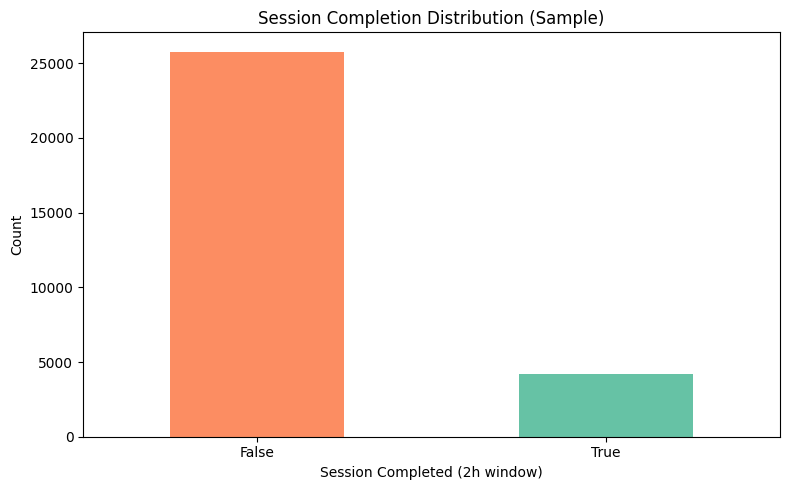

In [9]:
# Target variable analysis (pandas-based)
print("=== TARGET VARIABLE ANALYSIS ===\n")

# Session completion rate
completion_counts = df_train['session_end_completed'].value_counts()
print("Session completion distribution:")
print(completion_counts)

completion_pct = (completion_counts / completion_counts.sum() * 100)
print(f"\nCompletion rate (True): {completion_pct.get(True, 0):.2f}%")
print(f"Non-completion rate (False): {completion_pct.get(False, 0):.2f}%")

# Visualize
plt.figure(figsize=(8, 5))
completion_counts.plot(kind='bar', color=['#fc8d62', '#66c2a5'])
plt.title('Session Completion Distribution (Sample)')
plt.xlabel('Session Completed (2h window)')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

## 2. Categorical Variables Analysis

=== UI LANGUAGE DISTRIBUTION ===

Number of unique languages: 23

Top 10 languages:
ui_language
en    12150
es     7429
pt     2824
ru     1342
fr     1142
de      863
ar      573
it      521
zs      520
vi      478
Name: count, dtype: int64


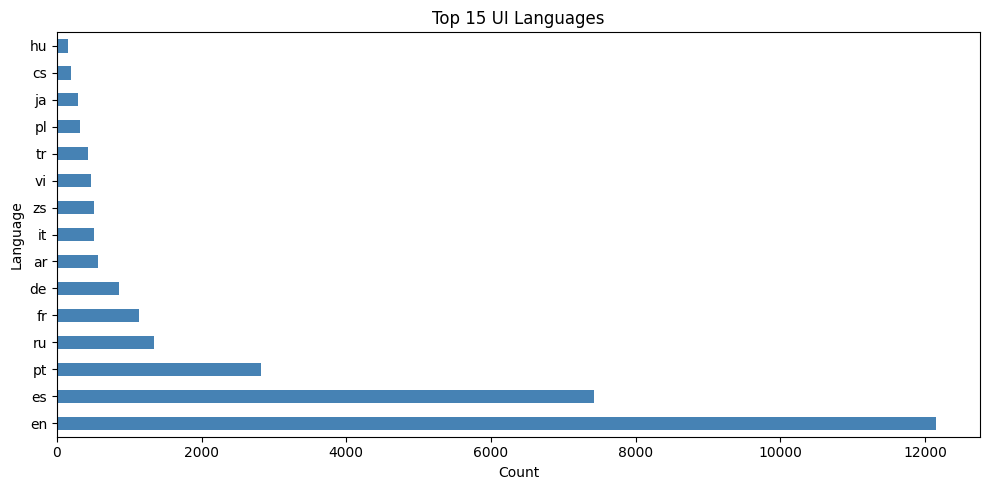



=== SELECTED TEMPLATE DISTRIBUTION ===

Number of unique templates: 11

Template distribution:
selected_template
H    3230
K    3134
D    3133
E    3125
F    3110
G    3062
J    3057
L    3036
B    3028
A    1207
C     878
Name: count, dtype: int64


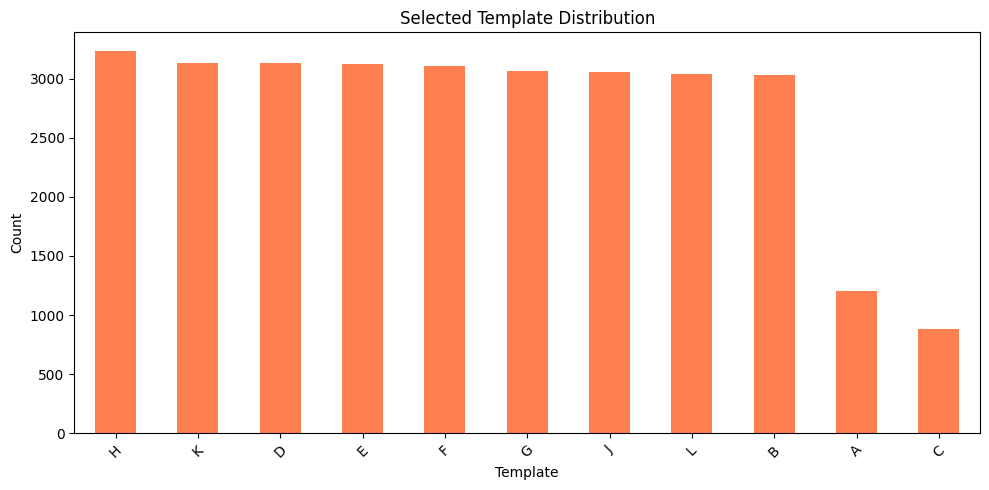

In [10]:
# UI Language distribution
print("=== UI LANGUAGE DISTRIBUTION ===\n")
lang_counts = df_train['ui_language'].value_counts()
print(f"Number of unique languages: {len(lang_counts)}")
print(f"\nTop 10 languages:")
print(lang_counts.head(10))

# Visualize top languages
plt.figure(figsize=(10, 5))
lang_counts.head(15).plot(kind='barh', color='steelblue')
plt.title('Top 15 UI Languages')
plt.xlabel('Count')
plt.ylabel('Language')
plt.tight_layout()
plt.show()

# Selected template distribution
print("\n\n=== SELECTED TEMPLATE DISTRIBUTION ===\n")
template_counts = df_train['selected_template'].value_counts()
print(f"Number of unique templates: {len(template_counts)}")
print(f"\nTemplate distribution:")
print(template_counts)

plt.figure(figsize=(10, 5))
template_counts.plot(kind='bar', color='coral')
plt.title('Selected Template Distribution')
plt.xlabel('Template')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 3. Bivariate Analysis: Features vs Target

=== COMPLETION RATE BY LANGUAGE ===

Top 10 languages by completion rate (min 10 samples):
             total  completed  completion_rate
ui_language                                   
ja             290         72         0.248276
pl             322         71         0.220497
de             863        164         0.190035
cs             195         34         0.174359
ko             110         19         0.172727
el              35          6         0.171429
hu             158         26         0.164557
en           12150       1933         0.159095
it             521         81         0.155470
ru            1342        204         0.152012


=== COMPLETION RATE BY TEMPLATE ===

                   total  completed  completion_rate
selected_template                                   
C                    878        352         0.400911
A                   1207        313         0.259321
J                   3057        409         0.133791
F                   3110        406      

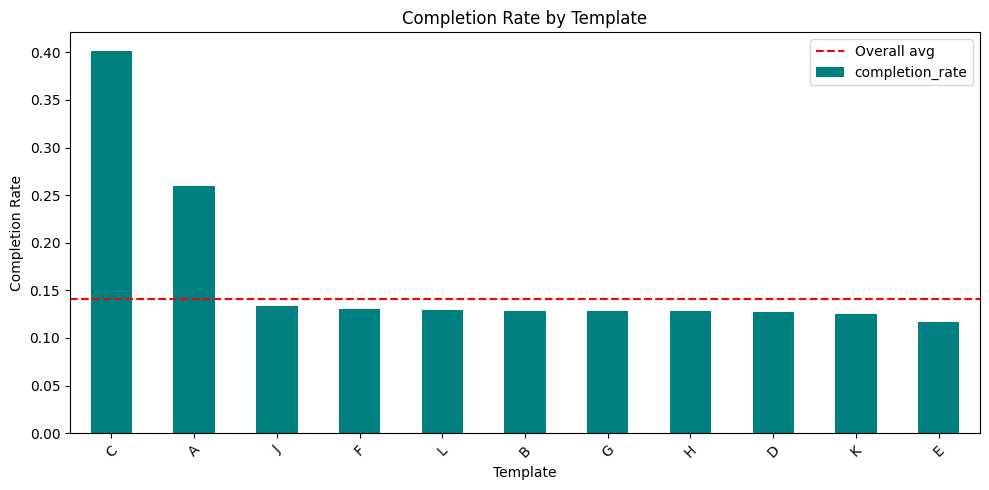

In [11]:
# Completion rate by language
print("=== COMPLETION RATE BY LANGUAGE ===\n")
lang_completion = df_train.groupby('ui_language')['session_end_completed'].agg([
    ('total', 'count'),
    ('completed', 'sum'),
    ('completion_rate', 'mean')
]).sort_values('completion_rate', ascending=False)

print("Top 10 languages by completion rate (min 10 samples):")
print(lang_completion[lang_completion['total'] >= 10].head(10))

# Completion rate by selected template
print("\n\n=== COMPLETION RATE BY TEMPLATE ===\n")
template_completion = df_train.groupby('selected_template')['session_end_completed'].agg([
    ('total', 'count'),
    ('completed', 'sum'),
    ('completion_rate', 'mean')
]).sort_values('completion_rate', ascending=False)

print(template_completion)

# Visualize
plt.figure(figsize=(10, 5))
template_completion['completion_rate'].plot(kind='bar', color='teal')
plt.title('Completion Rate by Template')
plt.xlabel('Template')
plt.ylabel('Completion Rate')
plt.axhline(y=df_train['session_end_completed'].mean(), color='red', linestyle='--', label='Overall avg')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 4. Nested Column Exploration

=== ELIGIBLE TEMPLATES ANALYSIS ===

Distribution of eligible template counts:
num_eligible_templates
1       878
2        21
3        43
9     17323
10    11735
Name: count, dtype: int64


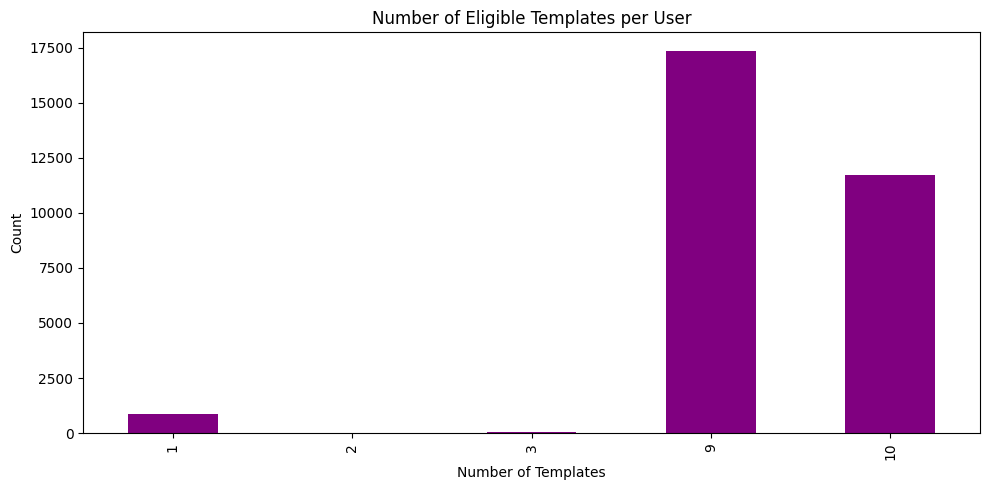



=== HISTORY COLUMN STRUCTURE ===

Sample history (first 3 rows):

Row 0:
  Type: <class 'numpy.ndarray'>
  Length: N/A

Row 1:
  Type: <class 'numpy.ndarray'>
  Length: N/A

Row 2:
  Type: <class 'numpy.ndarray'>
  Length: N/A


History length statistics:
count    30000.0
mean         0.0
std          0.0
min          0.0
25%          0.0
50%          0.0
75%          0.0
max          0.0
Name: history_length, dtype: float64


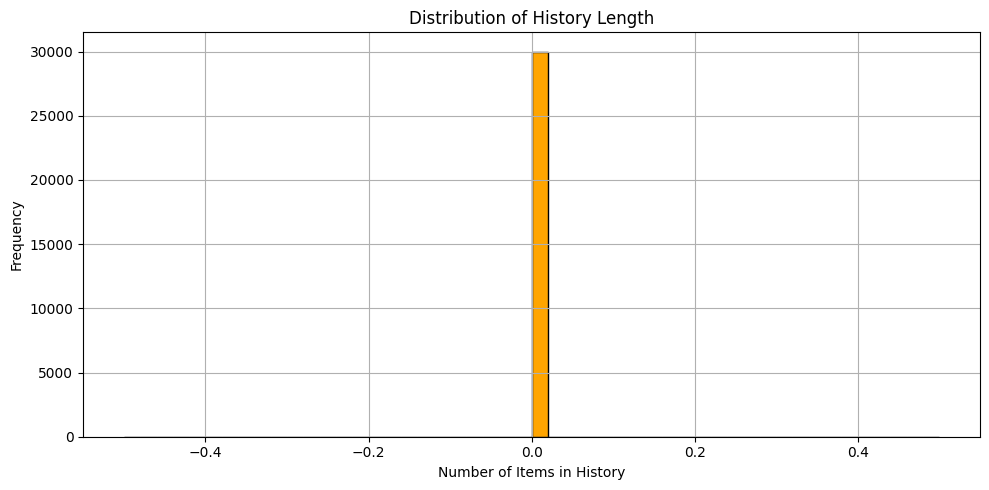

In [12]:
# Explore eligible_templates column (list of templates available)
print("=== ELIGIBLE TEMPLATES ANALYSIS ===\n")

# Number of eligible templates per row
df_train['num_eligible_templates'] = df_train['eligible_templates'].apply(len)
print(f"Distribution of eligible template counts:")
print(df_train['num_eligible_templates'].value_counts().sort_index())

plt.figure(figsize=(10, 5))
df_train['num_eligible_templates'].value_counts().sort_index().plot(kind='bar', color='purple')
plt.title('Number of Eligible Templates per User')
plt.xlabel('Number of Templates')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# Explore history column (nested list of dicts)
print("\n\n=== HISTORY COLUMN STRUCTURE ===\n")
print("Sample history (first 3 rows):")
for i, hist in enumerate(df_train['history'].head(3)):
    print(f"\nRow {i}:")
    print(f"  Type: {type(hist)}")
    print(f"  Length: {len(hist) if isinstance(hist, list) else 'N/A'}")
    if isinstance(hist, list) and len(hist) > 0:
        print(f"  First item: {hist[0]}")
        if len(hist) > 1:
            print(f"  Keys in history items: {list(hist[0].keys()) if isinstance(hist[0], dict) else 'Not a dict'}")

# History length distribution
df_train['history_length'] = df_train['history'].apply(lambda x: len(x) if isinstance(x, list) else 0)
print(f"\n\nHistory length statistics:")
print(df_train['history_length'].describe())

plt.figure(figsize=(10, 5))
df_train['history_length'].hist(bins=50, color='orange', edgecolor='black')
plt.title('Distribution of History Length')
plt.xlabel('Number of Items in History')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()